In [1]:
# LOAD
# TRAIN
# EVALUATE
# TRY ON CUSTOM DATA
#
# CNN STRUCTURE:
#    Conv Layer - 6 filters, 3x3 size, stride 1
#    Pooling Layer 2x2 stride of 2
#    Conv Layer - 16 filters, 3x3 size, stride 1
#    Pooling Layer 2x2 stride of 2
#    Fully Connected 46656 --> 120 --> 84 --> 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [4]:
root = 'PYTORCH_NOTEBOOKS/Data/CATS_DOGS/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes

In [5]:
class_names

['CAT', 'DOG']

In [6]:
len(train_data)

18743

In [7]:
len(test_data)

6251

In [8]:
for images, labels in train_loader:
    break

In [9]:
images.shape

torch.Size([10, 3, 224, 224])

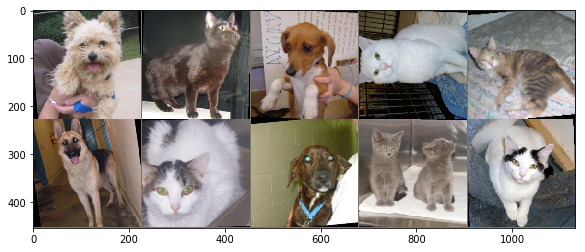

In [10]:
im = make_grid(images, nrow=5)

inverse_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inverse = inverse_normalize(im)

plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(im_inverse.numpy(), (1, 2, 0)))

In [11]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=6, 
            kernel_size=3, stride=1
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, 
            kernel_size=3, stride=1
        )
        
        # (((224 - 2) / 2) - 2) / 2 == 54.5
        #
        # 224 - 2
        # we have 224 size image and we have padding eqv 2 pixels
        # because when we perform our convolutional 
        # we lose pixels at the very border on both sides
        #
        # (224 - 2) / 2
        # then it will be divided by 2 because we apply 
        # pooling layer to that
        #
        # (((224 - 2) / 2) - 2) / 2 
        # again pass it through conv2 and pooling2 layers
        #
        # result equals 54.5 --> ROUND it --> 54 pixels per side
        #
        # (54 * 54 * 16) --> 54x54 pixels image with 16 filters 
        self.fc1 = nn.Linear(in_features=54 * 54 * 16, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = X.view(-1, 54*54*16) # flatten
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)
        
        

In [12]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [13]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [14]:
total_p = 0
for p in CNNmodel.parameters():
    total_p += p.numel()
    print(p.numel())
    
print(f'total params in model: {total_p}')

162
6
864
16
5598720
120
10080
84
168
2
total params in model: 5610222


In [15]:
import time
start_time = time.time()


epochs = 3

# optional to decrease time
# limits on num of batches
max_trn_batch = 800 # each batch has 10 images --> 8000 images
max_tst_batch = 300 # 3000 max images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # optimal ! 
        # limit number of batches
        if (b == max_trn_batch):
            break
            
        b+=1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
        # Tally the nuber of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (b%200 == 0):
            print(f'Epoch {i} LOSS: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # testing
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            # optional !
            if (b == max_tst_batch):
                break
                
            y_val = CNNmodel(X_test)
            
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
        

total_time = time.time() - start_time
print(f'Total Time: {total_time / 60} minutes')

Epoch 0 LOSS: 0.6710730791091919
Epoch 0 LOSS: 0.6924208402633667
Epoch 0 LOSS: 0.514548122882843
Epoch 0 LOSS: 0.5556958913803101
Epoch 1 LOSS: 0.42003947496414185
Epoch 1 LOSS: 0.49405956268310547
Epoch 1 LOSS: 0.7220004796981812
Epoch 1 LOSS: 0.49273568391799927
Epoch 2 LOSS: 0.6204346418380737
Epoch 2 LOSS: 0.4496847987174988
Epoch 2 LOSS: 0.4804299473762512
Epoch 2 LOSS: 0.40735381841659546
Total Time: 13.44361910422643 minutes


In [16]:
torch.save(CNNmodel.state_dict(), 'my3epochmodel.pt')

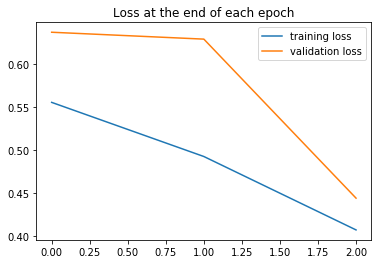

In [17]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

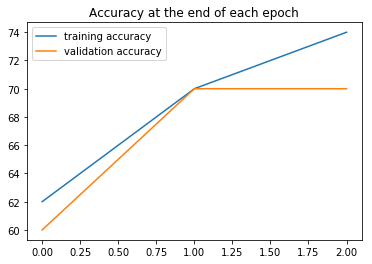

In [18]:
# 80 and 30 because of size of batches
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [19]:
# accuracy
100 * test_correct[-1].item() / 3000

70.0

In [20]:
# all pretrained model expect images 
# normalied is the same way, i.e. mini-batches
# of 3-channel RGB images of shape (3 x H x W),
# where H and W are expected to be at least 224
#
# the images have to be loaded in to a range of [0, 1]
# and the normalized using 
# mean=[0.485, 0.456, 0.406]
# and
# std=[0.229, 0.224, 0.225]
#
# we will use the AlexNet this time
AlexNetModel = models.alexnet(pretrained=True)

In [21]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [22]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [23]:
torch.manual_seed(42)

AlexNetModel.classifier = nn.Sequential(
    nn.Linear(
        in_features=9216, 
        out_features=1024
    ), 
    nn.ReLU(), 
    nn.Dropout(0.5), 
    nn.Linear(1024, 2), 
    nn.LogSoftmax(dim=1)
)

In [24]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [25]:
for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)

In [30]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetModel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.01675895  accuracy:  94.650%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.07451697  accuracy:  93.975%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.04634447  accuracy:  94.133%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.05777276  accuracy:  94.025%

Duration: 335 seconds


In [32]:
print(test_correct[-1].item() / 3000)

0.971


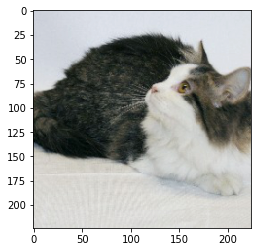

In [33]:
image_index = 2019

im = inverse_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [35]:
CNNmodel.eval()

with torch.no_grad():
    new_pred = CNNmodel(test_data[image_index][0].view(1, 3, 224, 224)).argmax()
    
class_names[new_pred.item()]

'CAT'

In [36]:
AlexNetModel.eval()

with torch.no_grad():
    new_pred = AlexNetModel(test_data[image_index][0].view(1, 3, 224, 224)).argmax()

class_names[new_pred.item()]

'CAT'

In [37]:
class_names

['CAT', 'DOG']